In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('daily-min-temperatures.csv', header=0)
series.plot()

--2019-07-15 15:08:21--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.192.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2019-07-15 15:08:21 (2.12 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [2]:
from pandas import Series
from matplotlib import pyplot
from numpy import polyfit
series = Series.from_csv('daily-min-temperatures.csv', header=0)


Coefficients: [-1.17308000e-08  9.30253946e-06 -2.15977594e-03  1.19147966e-01
  1.38980178e+01]


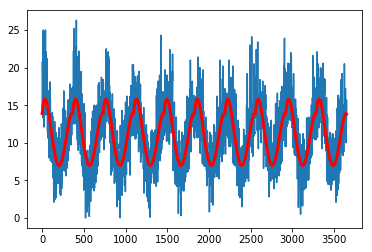

In [3]:
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
pyplot.plot(series.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()

In [4]:
#Custom functions and some extra requirements
from numpy.fft import fft, ifft, fftfreq, rfftfreq, rfft, irfft

#Returns the area to explore, along with feature names of the features with less than threshold percentage of nans.
def explore_nulls(cube,lat = -4.21, lon = -69.94, threshold = 25,spacing = 5):
    area_to_explore = cube.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    snull = area_to_explore.isnull()
    nnull = area_to_explore.notnull()
    viable_features=[]
    for i in area_to_explore.keys():
        count_null = snull[i].values.sum()
        count_nnull = nnull[i].values.sum()
        null_percentage = count_null/(count_null+count_nnull)*100
        if(null_percentage < threshold):
            print(i, "null_percentage = {:.2f}".format(null_percentage))
            viable_features.append(i)
    return area_to_explore, viable_features

#Authored by SaumyaBansal, lists the N highest values of a list
def Nmax(list1, N = 5): 
    final_list = [] 
    
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j];
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list
    
#Find the indexes corresponding to the position of the values of list_of_max in array.
def find_Index(array,list_of_max):
    indexes = []
    for i in range(len(list_of_max)):
            indexes.append(np.argwhere(array == list_of_max[i])[0][0])
    return indexes    


#Makes zero the Fourier coefficients of farray bigger than  thethreshold.
def clean_periodicity(farray, list_of_maxes, list_of_indexes, threshold = 5):
    for i in range(len(list_of_maxes)):
        if(list_of_maxes[i]> threshold):
            farray[list_of_indexes[i]] = 0
            
            
#Returns a pandas DataFrame with the seasonality-corrected viable features.
def clean_cube(cube, central_lat, central_lon, spacing, threshold = 25):
    cube_section, features = explore_nulls(cube,lat = central_lat, lon = central_lon,threshold = threshold,spacing = spacing)
    series = []
    cube_section.load() #RAM expensive, avoid large spacing values.
    for feature in features:
        series.append(clean_feature(cube_section, feature))
    
    #return pd.concat(series, axis=1)
    return series

# panda Series with the spatial median of the corrected feature.
def clean_feature(cube_section, feature_name):
    time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
    freq = rfftfreq(len(time_Series.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
    f_time_Series = rfft(time_Series)
    
    real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
    imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
    real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
    imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)
    
    clean_periodicity(f_time_Series.real,real_maxes,real_ii)
    clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)
    
    corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

    #Creates a new series 
    final_Series = pd.Series(corrected_time_Series)
    dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
    final_Series.index = dates
    
    return final_Series

In [5]:
time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
freq = rfftfreq(len(time_Series.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
f_time_Series = rfft(time_Series)

real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)

clean_periodicity(f_time_Series.real,real_maxes,real_ii)
clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)

corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

#Creates a new series 
final_Series = pd.Series(corrected_time_Series)
dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
final_Series.index = dates

return final_Series

NameError: name 'cube_section' is not defined

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

f_time_Series = rfft(series.values)
freq = rfftfreq(len(series.values), d=1)

f_time_Series[0] = 0

real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)

real_maxes, real_ii

imag_maxes, imag_ii

([3217.5007064537594,
  657.6028361058287,
  598.9918406721629,
  587.668519310583,
  579.2913184670703],
 [10, 20, 43, 1, 101])

In [7]:
np.array(imag_maxes)/f_time_Series.imag.sum()*100, imag_ii

(array([-25.84504331,  -5.28229061,  -4.81148925,  -4.72053302,
         -4.65324194]), [10, 20, 43, 1, 101])

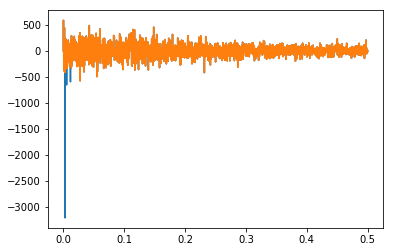

In [8]:


plt.plot(freq,f_time_Series.imag)

clean_periodicity(f_time_Series.real,real_maxes,real_ii,threshold=590)
clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii,threshold=590)
plt.plot(freq,f_time_Series.imag)

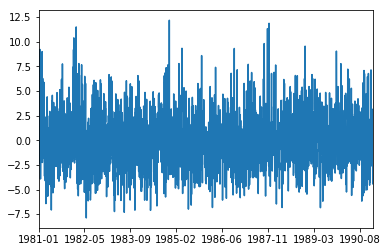

In [9]:
corrected_time_Series = irfft(f_time_Series, n = len(series))
final_Series = pd.Series(corrected_time_Series)
dates = np.datetime_as_string(series.keys().values,unit = 'M')
final_Series.index = dates
final_Series.plot()

In [10]:
dates = np.datetime_as_string(series.keys().values,unit = 'D')
dates

array(['1981-01-01', '1981-01-02', '1981-01-03', ..., '1990-12-29',
       '1990-12-30', '1990-12-31'], dtype='<U28')

In [11]:
series.keys().values

array(['1981-01-01T00:00:00.000000000', '1981-01-02T00:00:00.000000000',
       '1981-01-03T00:00:00.000000000', ...,
       '1990-12-29T00:00:00.000000000', '1990-12-30T00:00:00.000000000',
       '1990-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [58]:
freq[43]**-1/365

0.23255813953488372